<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/notebooks/handwriting-recognition-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwriting Recognition - Pytorch

This notebook contains code to create a deep learning handwriting recognition
model in Pytorch. The model is for offline handwritten text using
line-level segmentations. It is an implementation of the paper,
*Are Multidimensional Recurrent Layers Really Necessary for Handwritten Text Recognition?* as
recorded in [Puigcerver](http://www.jpuigcerver.net/pubs/jpuigcerver_icdar2017.pdf).

### Imports

In [0]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

# Make sure we are using a GPU on Colab
assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

# Data Structures
import numpy as np
import pandas as pd
import cv2
import csv
import json

# Python
import os
import time
import tarfile
import gzip
import gc

# Image/Plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps
from tqdm import tqdm

# Colab (We can use this if we want to import files from Google Drive)
# from google.colab import drive
# drive.mount('/content/drive')

# Debugging
import pdb
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

### Download the Dataset

We will be using a very common handwriting dataset called [IAM](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database).

Download and unzip the dataset from the BYU-Handwriting-Lab Google Drive (courtesy of a clever wget command described [here](https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99)). In many
instances, we would probably make use of the google.drive API that allows
us to mount our Google drive here in Colab; however, we use this method
because it doesn't require us to authenticate.

A char_set.json file is also downloaded which contains a mapping between
characters and indices.

In [0]:
# ID = 1-kVwdAU3ir86PU9ouwblnvcK7pEQ1yyn
# FILENAME = iam-line-level.zip
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-kVwdAU3ir86PU9ouwblnvcK7pEQ1yyn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-kVwdAU3ir86PU9ouwblnvcK7pEQ1yyn" -O iam-line-level.zip && rm -rf /tmp/cookies.txt
!unzip -q iam-line-level.zip -d iam
!rm iam-line-level.zip
!wget -q https://raw.githubusercontent.com/BYU-Handwriting-Lab/GettingStarted/master/data/char_set.json

Make sure we have the *char_set.json* file and *iam/* directory.

In [4]:
!ls

char_set.json  iam  sample_data


In [200]:
cat char_set.json

{"idx_to_char": {"1": " ", "2": "!", "3": "\"", "4": "#", "5": "$", "6": "%", "7": "&", "8": "'", "9": "(", "10": ")", "11": "*", "12": "+", "13": ",", "14": "-", "15": ".", "16": "/", "17": "0", "18": "1", "19": "2", "20": "3", "21": "4", "22": "5", "23": "6", "24": "7", "25": "8", "26": "9", "27": ":", "28": ";", "29": "=", "30": "?", "31": "A", "32": "B", "33": "C", "34": "D", "35": "E", "36": "F", "37": "G", "38": "H", "39": "I", "40": "J", "41": "K", "42": "L", "43": "M", "44": "N", "45": "O", "46": "P", "47": "Q", "48": "R", "49": "S", "50": "T", "51": "U", "52": "V", "53": "W", "54": "X", "55": "Y", "56": "Z", "57": "[", "58": "]", "59": "_", "60": "`", "61": "a", "62": "b", "63": "c", "64": "d", "65": "e", "66": "f", "67": "g", "68": "h", "69": "i", "70": "j", "71": "k", "72": "l", "73": "m", "74": "n", "75": "o", "76": "p", "77": "q", "78": "r", "79": "s", "80": "t", "81": "u", "82": "v", "83": "w", "84": "x", "85": "y", "86": "z", "87": "|", "88": "~", "89": "\u00a3", "90": "

### Encoder/Decoder Class

This class allows us to map between string labels and actual index tensors that
represent a string.

In [0]:
class Encoder():
  def __init__(self, sequence_size=128):
    with open('char_set.json') as file:
      self.json = json.load(file)
    
    self.sequence_size = sequence_size

  def remove_duplicates(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      if i + 1 == len(idxs) or idxs[i] != idxs[i + 1]:
        new_idxs.append(idxs[i])
    
    return new_idxs
  
  def add_blanks(self, idxs):
    new_idxs = []

    for i in range(len(idxs)):
      new_idxs.append(idxs[i])
      if i + 1 != len(idxs) and idxs[i] == idxs[i + 1]:
        new_idxs.append(0)
    
    return new_idxs
  
  def idx_to_char(self, idx):
    if idx == 0:
      return ''
    else:
      return self.json['idx_to_char'][str(int(idx))]
  
  def char_to_idx(self, char):
    return int(self.json['char_to_idx'][char])
  
  def str_to_idxs(self, string):
    idxs = []

    zeros = np.zeros(self.sequence_size)

    for char in string:
      idxs.append(self.char_to_idx(char))

    # Add blanks if CTC-Loss requires it...
    # idxs = self.add_blanks(idxs)

    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]
    
    return idxs

  def idxs_to_str(self, idxs, remove_duplicates=True):
    string = ''

    if remove_duplicates:
      idxs = self.remove_duplicates(idxs)

    for idx in idxs:
      string += self.idx_to_char(idx)
    
    return string
  
  def str_to_idxs_batch(self, batch):
    idxs = []

    for string in batch:
      idx = self.str_to_idxs(string)
      idxs.append(idx)

    return idxs
  
  def idxs_to_str_batch(self, batch, remove_duplicates=True):
    strings = []

    for idxs in batch:
      strings.append(self.idxs_to_str(idxs, remove_duplicates=remove_duplicates))
    
    return strings

### Helper Functions

A quick helper function that will display a few images for us when we display
our results.

The second will simply count the number of characters in a label (up to a max
sequence size). We will use this when we calculate the loss for CTC in our
training loop.

In [0]:
def show_imgs(x, new_fig=True, figsize=(16,16)):
    grid = utils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure(figsize=figsize)
    plt.imshow(grid.numpy())

def word_lengths_tensor(words, sequence_size=128):
  lengths = []

  if type(words) == str:
    length = len(word)
    if length > sequence_size:
      length = sequence_size
    lengths.append(length)
    return torch.tensor(lengths)
  else:
    for word in words:
      length = len(word)
      if length > sequence_size:
        length = sequence_size
      lengths.append(length)
    return torch.tensor(lengths)

### Dataset

To create a dataset in Pytorch, we extend the *Dataset* class and implement the
*\_\_getitem\_\_* and *\_\_len\_\_* methods. We also use a couple other
methods to resize the image and transform it to a tensor.

In [0]:
class IamDataset(Dataset):
  def __init__(self, desired_size=(64, 1024), total_imgs=None):
    self.img_path = '/content/iam/images/'
    labels_path = '/content/iam/labels.csv'

    if not os.path.exists(labels_path) or not os.path.exists(self.img_path):
      raise Exception('Iam dataset does not exist in ' + labels_path)

    self.desired_size = desired_size
    self.df = pd.read_csv('/content/iam/labels.csv', header=None, sep='\t', names=['word', 'transcription'], quoting=csv.QUOTE_NONE)
    if total_imgs != None:
      self.df = self.df[:total_imgs]

    self.encoder = Encoder(sequence_size=128)

  def resize(self, img, desired_size):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = desired_size[0] / desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = desired_size[0]
      new_width = int(desired_size[0] // img_ratio)
    else:
      # Solve by width
      new_height = int(desired_size[1] * img_ratio)
      new_width = desired_size[1]

    img = np.array(img.resize((new_width, new_height)))

    border_top = desired_size[0] - new_height
    border_right = desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=255)

    return img

  def tensor_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img, self.desired_size)
    x = transforms.functional.to_tensor(img)

    return x

  def __getitem__(self, index):
    img = self.tensor_image(self.img_path + self.df['word'][index])

    return img, self.df['transcription'][index]

  def __len__(self):
    return len(self.df)

Check to make sure our dataset is giving us what we expect

Tensor Shape: torch.Size([1, 64, 1024])
Label: A MOVE to stop Mr. Gaitskell from


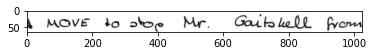

In [8]:
dataset = IamDataset()
img, label = dataset[0]

print('Tensor Shape:', img.shape)
print('Label:', label)
imshow(img.squeeze(), cmap='gray')

### Handwriting Recognition Model

We follow the architecture given by [Puigcerver](http://www.jpuigcerver.net/pubs/jpuigcerver_icdar2017.pdf).

Diagram [reference](https://medium.com/@arthurflor23/handwritten-text-recognition-using-tensorflow-2-0-f4352b7afe16)

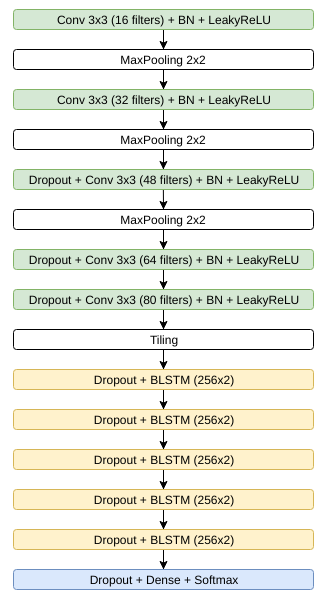

In [0]:
class Recognizer(nn.Module):
  def __init__(self):
    super(Recognizer, self).__init__()

    self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU())
    self.mp1 = nn.MaxPool2d(2)
    self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU())
    self.mp2 = nn.MaxPool2d(2)
    self.conv3 = nn.Sequential(nn.Dropout(p=0.2), nn.Conv2d(32, 48, 3, 1, 1), nn.BatchNorm2d(48), nn.LeakyReLU())
    self.mp3 = nn.MaxPool2d(2)
    self.conv4 = nn.Sequential(nn.Dropout(p=0.2), nn.Conv2d(48, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.LeakyReLU())
    self.conv5 = nn.Sequential(nn.Dropout2d(p=0.2), nn.Conv2d(64, 80, 3, 1, 1), nn.BatchNorm2d(80), nn.LeakyReLU())

    self.mp4 = nn.MaxPool2d((8, 1))

    self.lstm1 = nn.Sequential(nn.Dropout2d(p=0.2), nn.LSTM(80, 128, 1, bidirectional=True, batch_first=True))
    self.lstm2 = nn.Sequential(nn.Dropout2d(p=0.2), nn.LSTM(256, 128, 1, bidirectional=True, batch_first=True))
    self.lstm3 = nn.Sequential(nn.Dropout2d(p=0.2), nn.LSTM(256, 128, 1, bidirectional=True, batch_first=True))
    self.lstm4 = nn.Sequential(nn.Dropout2d(p=0.2), nn.LSTM(256, 128, 1, bidirectional=True, batch_first=True))

    self.final = nn.Sequential(nn.Dropout2d(p=0.2), nn.Linear(256, 197))
    self.softmax = nn.LogSoftmax(dim=2)

  def forward(self, x):
    # Encoder
    out = self.conv1(x)
    out = self.mp1(out)
    out = self.conv2(out)
    out = self.mp2(out)
    out = self.conv3(out)
    out = self.mp3(out)
    out = self.conv4(out)
    out = self.conv5(out)

    out = self.mp4(out)
    out = out.squeeze(2)
    out = out.permute(0, 2, 1)

    # Decoder
    out, _ = self.lstm1(out)
    out, _ = self.lstm2(out)
    out, _ = self.lstm3(out)
    out, _ = self.lstm4(out)

    out = self.final(out)

    out = self.softmax(out)

    out = out.permute(1, 0, 2)

    return out

Run an image through our model just to make sure it works!

In [0]:
model = Recognizer()
encoder = Encoder(sequence_size=128)
image, label = IamDataset()[0]

Notice the output shape of the model (Sequence Size, Batch Size, Num Classes).

The model outputs tensors with this shape to easily pass to the CTC Loss
function. To get it into a format that we can decode, we just need to reshape
the output slightly (Batch Size, Sequence Size, Num Classes).

In [309]:
model = Recognizer()
pred = model(image.unsqueeze(0))
print(pred.shape)
pred = pred.permute(1, 0, 2)
print(pred.shape)

torch.Size([128, 1, 197])

Prediction: fδ|δTδ|TδTδTδTδT|δTδ|T|δTδTδTδTδTδT|δT|δ|TδTδT|Tδ|TδTδT|δ
Target: A MOVE to stop Mr. Gaitskell from


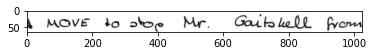

In [284]:
prediction = encoder.idxs_to_str_batch(pred.argmax(dim=2))[0]

print('Prediction:', prediction)
print('Target:', label)
imshow(img.squeeze(), cmap='gray')

### Training

Train the handwriting recognition model. Here we train for 200 epochs, with a
batch size of 100. Handwriting recognition models are trained using CTC-Loss
which works well with sequential information.

In [0]:
def train():
  NUM_EPOCHS = 100
  BATCH_SIZE = 64
  SEQUENCE_SIZE = 128

  dataset = IamDataset()
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * .8), len(dataset) - int((len(dataset) * .8))])

  train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=4)
  val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=True, num_workers=4)

  model = Recognizer().cuda()
  encoder = Encoder(sequence_size=SEQUENCE_SIZE)
  objective = nn.CTCLoss(blank=0, reduction='none', zero_infinity=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)

  train_losses = []
  val_losses = []

  for epoch in range(NUM_EPOCHS):

    train_epoch_loss = []
    val_epoch_loss = []

    # Train Loop
    train_loop = tqdm(total=len(train_loader), position=0, leave=True)
    model.train()
    for batch_num, (imgs, words) in enumerate(train_loader):
      batch_size = imgs.shape[0]

      imgs, labels = imgs.cuda(), torch.tensor(encoder.str_to_idxs_batch(words))

      preds = model(imgs)
      input_lengths = torch.full(size=(batch_size,), fill_value=SEQUENCE_SIZE, dtype=torch.long)
      label_lengths = word_lengths_tensor(words, sequence_size=SEQUENCE_SIZE)

      loss = objective(preds, labels, input_lengths, label_lengths)
      loss = torch.mean(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_epoch_loss.append(loss.item())

      train_loop.set_description('Train - Epoch: {}, Loss: {:.4}, AvgLoss: {:.4}'.format(epoch, loss.item(), np.mean(train_epoch_loss)))
      train_loop.update(1)
    
    train_loop.close()

    # Validation Loop
    val_loop = tqdm(total=len(val_loader), position=0, leave=True)
    model.eval()
    for batch_num, (imgs, words) in enumerate(val_loader):
      batch_size = imgs.shape[0]

      imgs, labels = imgs.cuda(), torch.tensor(encoder.str_to_idxs_batch(words))

      preds = model(imgs)
      input_lengths = torch.full(size=(batch_size,), fill_value=SEQUENCE_SIZE, dtype=torch.long)
      label_lengths = word_lengths_tensor(words, sequence_size=SEQUENCE_SIZE)

      loss = objective(preds, labels, input_lengths, label_lengths)
      loss = torch.mean(loss)

      val_epoch_loss.append(loss.item())

      val_loop.set_description('Val  - Epoch: {}, Loss: {:.4f}, AvgLoss: {:.4f}'.format(epoch, loss.item(), np.mean(val_epoch_loss)))
      val_loop.update(1)

    val_loop.close()

    train_losses.append(np.mean(train_epoch_loss))
    val_losses.append(np.mean(val_epoch_loss))
  
  return model, train_losses, val_losses

In [319]:
recognizer, train_losses, val_losses = train()

Val  - Epoch: 99, Loss: 17.22, AvgLoss: 15.24: 100%|██████████| 36/36 [00:06<00:00,  5.36it/s]


Save the weights to our model if desired.

In [0]:
torch.save(recognizer.state_dict(), 'recognizer.model')

In [335]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cp 'recognizer.model' '/content/drive/My Drive/datasets'

In [339]:
!ls -l

total 6068
-rw-r--r-- 1 root root    5213 May 15 19:18 char_set.json
drwx------ 4 root root    4096 May 15 23:29 drive
drwxr-xr-x 3 root root    4096 May 15 19:18 iam
-rw-r--r-- 1 root root 6190574 May 15 23:28 recognizer.model
drwxr-xr-x 1 root root    4096 May 13 16:29 sample_data


In [342]:
!ls '/content/drive/My Drive/datasets'

esposalles-test.zip		     hwr_model4		 rimes-line-level.zip
esposalles.zip			     iam-line-level.zip  rimes.zip
french_record_detection_dataset.zip  iam.zip		 test_annos.json
hwr_model1			     maskrcnn.h5	 train_annos.json
hwr_model2			     missionary.tar.gz
hwr_model3			     recognizer.model


### Results

Display the loss curve of the model over time on both the training and
validation sets.

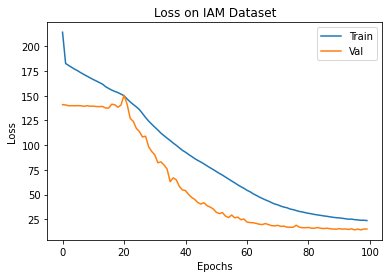

In [320]:
plt.title('Loss on IAM Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.legend()
plt.show()

### Samples

Let's test a few to get a feel for how our model is performing.

torch.Size([20, 128])
torch.Size([128, 197])


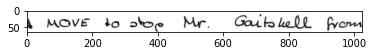

tensor([ 18,  18,  18, 115,  18, 115,  18, 115,  18, 115, 159, 159, 159, 159,
        159, 159,  18,  18, 115,  18,  18, 159, 130,  18,  18,  18,  18,  18,
         18,  18,  18, 115,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18,
        159, 130,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18,
         18, 159, 159, 115,  18,  18, 115,  18, 115, 115, 115,  30, 115, 130,
         18, 115, 130, 115,  18,  18,  18, 159,  18,  18, 115, 115, 115,  18,
        115,  18, 115,  18,  18,  18,  18,  18, 115, 115, 130,  18,  18,  18,
        115, 115,  18, 115, 115, 159, 159, 159,  18,  18,  18,  18,  18, 159,
        159, 159, 115, 115,  18, 115, 118,  18,  18,  18,  18, 115,  18,  18,
         18,  18], grad_fn=<NotImplemented>)
Prediction: ['1à1à1à1àρ1à1ρó1à1ρó1ρà1à1à?àó1àóà1ρ1à1à1à1àó1à1àρ1ρà1àä1à1']
Target: A MOVE to stop Mr. Gaitskell from
torch.Size([128, 197])


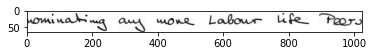

tensor([ 18,  18,  18, 115, 130, 130, 130, 130, 115,  18, 118, 118, 118,  18,
         18,  18,  18, 115, 118, 118, 118,  18,  18, 143, 143,  18,  18,  18,
         18,  18, 115, 115,  18,  18, 130, 115,  18,  18,  18,  18,  18,  18,
        159, 115,  18, 115,  18,  18, 159, 159, 159, 159, 159, 115, 159,  18,
        159,  18,  18, 115, 115, 115,  18,  18, 143, 115, 115, 118, 118, 115,
         18,  18,  18, 143, 143, 115,  18,  18, 130,  18,  18,  18,  18,  18,
         18,  18, 115,  18,  18,  18,  18, 118, 118,  18,  18, 115,  18, 159,
        159, 130,  18, 159, 130,  18, 115, 130, 118,  18,  18, 115, 118, 118,
        118,  18,  18,  18, 130, 130, 130, 130, 130, 115, 159, 159,  18, 115,
        115,  18], grad_fn=<NotImplemented>)
Prediction: ['1àóà1ä1àä1Ζ1à1óà1ρà1à1ρàρ1ρ1à1Ζàäà1Ζà1ó1à1ä1à1ρó1ρó1àóä1àä1óàρ1à1']
Target: nominating any more Labour life Peers
torch.Size([128, 197])


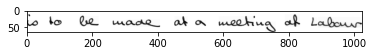

tensor([ 18,  18,  18,  18, 130,  18, 115,  30,  30,  30, 115, 115, 159, 115,
        115,  18, 159, 115, 159, 115,  30,  30,  30,  30,  30, 115, 130, 130,
        115, 130, 130, 118,  18, 130, 118,  30,  30, 115,  30, 159,  30, 115,
         30,  30,  30, 115,  30,  30, 159,  30,  30,  30,  30,  30,  30, 115,
         18,  18, 159, 130, 159, 130, 130, 159, 159,  30,  30,  30,  30,  30,
         30, 115, 115,  30,  30,  30, 118, 115,  30,  30,  30,  30,  30,  30,
         30, 159, 130, 130, 115, 115, 130, 159, 130, 130, 159,  30,  30, 115,
         30, 115,  30, 115,  30,  30, 115, 115, 159,  30, 159, 115, 130, 130,
        130, 130, 130,  18, 115,  30, 115, 115,  30, 115,  30,  30, 143, 143,
        130, 130], grad_fn=<NotImplemented>)
Prediction: ['1ó1à?àρà1ρàρà?àóàóä1óä?à?ρ?à?à?ρ?à1ρóρóρ?à?äà?ρóàóρóρ?à?à?à?àρ?ρàó1à?à?à?Ζó']
Target: is to be made at a meeting of Labour
torch.Size([128, 197])


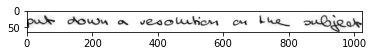

tensor([ 18,  18,  18,  18,  18,  18, 115, 115,  18,  18,  18,  30, 115,  18,
         18,  18,  18,  18,  18,  18,  18,  18, 159, 159, 115,  18, 115,  18,
        115, 115,  18, 115,  18,  18,  18,  18,  18, 115,  18,  18,  18,  18,
         18,  18,  18,  18, 115,  18, 115, 115,  18,  18,  18,  18,  18,  18,
        115,  18,  18,  18,  18,  18, 115,  18,  18,  18,  18,  18,  18,  18,
         18, 115, 130,  18,  18,  18,  18, 115, 115, 115,  18,  18,  18,  18,
        115,  18,  18,  18,  18,  18,  18,  18, 115,  18, 115,  18,  18, 115,
         18,  18,  18,  18,  18, 118, 115,  18,  18, 115,  18,  18,  18,  18,
         18,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18, 115,
         18,  18], grad_fn=<NotImplemented>)
Prediction: ['1à1?à1ρà1à1à1à1à1à1à1à1à1àó1à1à1à1à1à1äà1à1à1']
Target: put down a resolution on the subject
torch.Size([128, 197])


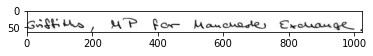

tensor([  0,  18,  18,  18,  18, 115,  18,  18,  18,  18,  18,  18,  18,  18,
         18,  18, 115,  18,  18,  18,  18, 159, 159, 115,  18,  18, 159, 115,
         18,  18, 118, 118, 118, 118, 159, 159, 115,  18,  18, 159,  18, 115,
         18, 159,  18,  18,  18,  18,  18,  18, 159, 159,  18, 115,  18, 143,
         18,  18, 115,  18, 159, 159, 159,  18,  30,  30, 159,  30,  18, 159,
         18,  18, 115,  18,  18,  18, 115,  18,  18,  18,  18,  18,  18,  18,
         18,  18, 115, 143, 115, 159, 159, 115, 118, 115, 118, 118,  18, 115,
        115, 115,  18,  18,  18,  18,  18, 159, 159, 159, 143, 143, 143, 115,
         18, 115,  18, 115, 130,  18, 159, 159, 115, 130, 115,  18,  18,  18,
        159,  18], grad_fn=<NotImplemented>)
Prediction: ['1à1à1ρà1ρà1äρà1ρ1à1ρ1ρ1à1Ζ1à1ρ1?ρ?1ρ1à1à1àΖàρàäàä1à1ρΖà1à1àó1ρàóà1ρ1']
Target: Griffiths, M P for Manchester Exchange.
torch.Size([128, 197])


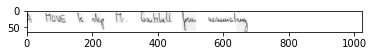

tensor([ 18,  18, 115, 115, 115,  30,  18,  18,  18,  18,  18,  30,  30, 115,
        115,  30,  30,  18,  30,  30,  30,  30,  30, 115, 115,  18, 115,  18,
         30,  30,  30, 115,  30,  76,  76, 159, 159, 159, 159, 159, 115,  18,
         18, 115,  18,  30, 115,  30,  30,  30,  18, 115,  18,  18,  30,  30,
         18, 115,  18,  18, 115, 159, 159, 115,  18, 159,  18,  18,  18,  18,
         18,  18,  18,  18,  18,  18,  18, 115,  18, 115,  18,  18, 115, 115,
        115, 115,  18, 115,  18,  18,  18, 159,  18, 159, 159,  18, 159,  18,
         18,  18, 115,  18,  18,  18,  76,  76,  76, 159,  18,  18,  18,  18,
        115, 159,  18,  18, 115,  18,  18,  18,  18,  18,  18,  18,  18,  76,
         76, 159], grad_fn=<NotImplemented>)
Prediction: ['1à?1?à?1?à1à1?à?pρà1à1?à?1à1?1à1àρà1ρ1à1à1à1à1ρ1ρ1ρ1à1pρ1àρ1à1pρ']
Target: A MOVE to stop Mr. Gaitskell from nominating
torch.Size([128, 197])


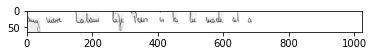

tensor([ 18,  18,  18,  18, 115,  18,  18,  18,  18, 115, 115,  18, 115,  18,
        159,  18, 115, 115, 115,  18,  18,  18, 115, 115,  18, 115,  18, 159,
         18, 159,  18,  18, 115,  18, 115,  18, 115,  18,  18,  18,  18, 115,
         18, 115,  30,  30,  30, 115,  18, 159, 118, 115, 118, 115, 115,  18,
         18,  18,  18,  18, 159,  18,  18,  18,  18,  18, 159, 159, 159, 115,
        115,  18,  18,  18, 115,  18,  18, 115, 115, 115, 159, 159, 130, 115,
        115,  18, 115, 159, 159, 159, 159, 159, 159, 159, 115, 115, 159,  18,
         18, 159, 159, 115, 159, 159, 115, 159, 159,  18, 115, 159, 159, 159,
         18,  18, 115,  18, 159, 159, 159, 159, 115, 159, 115, 159,  18,  18,
         18,  76], grad_fn=<NotImplemented>)
Prediction: ['1à1à1à1ρ1à1à1à1ρ1ρ1à1à1à1à1à?à1ρäàäà1ρ1ρà1à1àρóà1àρàρ1ρàρàρ1àρ1à1ρàρàρ1p']
Target: any more Labour life Peers is to be made at a
torch.Size([128, 197])


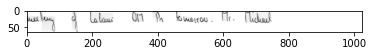

tensor([115,  18,  18,  18,  18,  18,  18,  18, 115, 159, 159,  18,  18,  18,
         18, 115, 115, 159,  18, 115, 115,  30,  30,  18,  18,  18,  18,  18,
         18,  18, 115,  30,  30, 115, 159, 115, 143, 115, 159, 115,  18,  18,
        159, 115,  18,  18,  18,  18,  18,  18, 159, 159, 159,  18,  18, 115,
         18,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18,  18, 115,  18,
        115, 115, 115,  18,  18,  18,  18, 159, 115, 159, 159,  18, 159,  18,
        115,  18,  18, 115,  18, 159, 159, 159,  18,  18, 159, 115, 115,  18,
        159, 115, 159, 159, 159,  18, 115,  18,  18, 115, 115, 159, 159, 159,
        159, 118, 118, 115, 118, 159,  18,  76, 159,  18,  18,  18, 115,  18,
        115,  76], grad_fn=<NotImplemented>)
Prediction: ['à1àρ1àρ1à?1à?àρàΖàρà1ρà1ρ1à1à1à1ρàρ1ρ1à1à1ρ1ρà1ρàρ1à1àρäàäρ1pρ1à1àp']
Target: meeting of Labour 0M Ps tomorrow. Mr. Michael
torch.Size([128, 197])


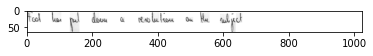

tensor([ 18,  18,  18,  18, 115,  18, 118, 115, 115,  18,  18,  18, 115, 115,
        118, 118, 118, 115, 115,  18,  18,  18,  18, 118, 118, 118, 118, 118,
         18, 159, 115,  18,  18, 159, 159, 159,  18,  18, 118, 115,  18,  18,
        115, 159, 115,  18, 159,  18, 159,  18, 115, 115, 118, 115, 115, 118,
        115,  18,  18, 159, 118, 118, 118, 118,  18,  18,  18, 115, 115, 159,
        118, 118, 159, 118, 118, 115, 118, 115, 118, 159,  18, 159,  18,  18,
         18, 159, 159,  18,  18,  18,  18, 118, 115, 115, 118, 118, 115, 115,
        115, 115, 118, 118, 118, 118, 118, 118, 118, 115, 118, 118, 115, 115,
        118, 118, 118, 118, 118, 118, 118, 115, 159, 159, 159, 115, 159, 159,
        159, 159], grad_fn=<NotImplemented>)
Prediction: ['1à1äà1àäà1ä1ρà1ρ1äà1àρà1ρ1ρ1àäàäà1ρä1àρäρäàäàäρ1ρ1ρ1äàäàäàäàäàρàρ']
Target: Foot has put down a resolution on the subject
torch.Size([128, 197])


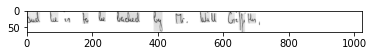

tensor([115,  18,  18, 115,  18,  30,  30,  30, 115,  30,  30,  30,  30,  30,
        115,  30, 159, 159, 159, 159,  18, 115,  18, 115,  18,  18,  18,  30,
         30, 115, 159, 159, 159, 159, 159, 115,  18,  18,  18, 115,  18,  18,
         18, 159,  18, 115,  18,  18,  18,  18,  18,  18,  18,  18, 115, 115,
         30, 115, 159,  30,  30,  76, 159, 159, 159, 115, 159,  18, 115,  18,
         18,  18,  18, 115,  18,  18,  18,  18, 115,  30,  30,  30,  30,  30,
         18,  18, 159,  18, 115,  18, 159, 159, 159, 115,  18, 115,  18,  18,
        159, 159, 118,  30,  30, 173,  76, 159,  18,  18,  76, 159, 159, 159,
        159,  18,  18, 115, 159, 159, 115, 130, 130, 130,  76,  76, 159, 115,
         18,  76], grad_fn=<NotImplemented>)
Prediction: ['à1à1?à?à?ρ1à1à1?àρà1à1ρ1à1à?àρ?pρàρ1à1à1à?1ρ1à1ρà1à1ρä?‰pρ1pρ1àρàópρà1p']
Target: and he is to be backed by Mr. Will Griffiths,
torch.Size([128, 197])


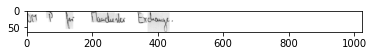

tensor([ 18,  18,  18,  18,  18, 159, 159, 159, 159,  18, 159,  30,  30, 115,
         18, 115,  30,  30,  30,  18, 159,  18, 159, 159,  18,  18,  18, 115,
         18,  18, 159, 159, 115, 115,  30, 115,  30,  30,  18, 130,  18,  18,
         18,  18, 159,  18, 159, 115,  18, 159,  18,  18,  18, 159, 159, 115,
        115, 115, 130, 159, 159,  18, 159, 115, 115, 115,  18, 159, 159, 115,
        115, 159, 159, 115, 115, 159,  18, 159, 130, 130,  18,  18, 159, 159,
        159, 115, 159, 159, 130, 130, 159, 159, 159, 159, 130,  18,  18, 115,
         18,  18, 115, 159,  18, 115, 115, 159,  18, 159, 159, 159, 159, 159,
        115, 115,  18, 115, 115, 115, 159, 159, 159, 159, 115, 159, 115, 115,
        115,  18], grad_fn=<NotImplemented>)
Prediction: ['1ρ1ρ?à1à?1ρ1ρ1à1ρà?à?1ó1ρ1ρà1ρ1ρàóρ1ρà1ρàρàρ1ρó1ρàρóρó1à1àρ1àρ1ρà1àρàρà1']
Target: 0M P for Manchester Exchange.
torch.Size([128, 197])


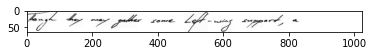

tensor([ 18,  18,  18,  18,  18, 115,  18, 130, 130, 159, 115, 130, 130, 115,
         18, 159, 159,  18, 115,  18, 115, 130,  30, 130, 130, 130, 130, 130,
        130, 130,  18,  18,  18,  18,  18,  18,  18, 115,  18, 115, 159, 115,
        130, 115,  18,  18, 115,  18,  18,  18,  18,  18,  30,  30, 130, 130,
        159, 118, 118, 115, 115, 115,  18,  18,  18, 159, 115,  18,  18, 115,
        130, 115,  18,  30,  18,  30,  30, 143, 130,  18,  18,  18,  18,  18,
         18,  18, 115,  30, 115, 159, 130,  18, 159, 130, 130, 159, 130, 130,
         18, 159,  18, 159, 159, 159, 159, 130, 130, 130, 115, 115, 118, 118,
        118, 159, 118, 159, 118, 118, 130, 159, 130, 118, 118, 115,  18, 115,
         18,  18], grad_fn=<NotImplemented>)
Prediction: ['1à1óρàóà1ρ1à1àó?ó1à1àρàóà1à1?óρäà1ρà1àóà1?1?Ζó1à?àρó1ρóρó1ρ1ρóàäρäρäóρóäà1à1']
Target: Though they may gather some Left-wing support, a
torch.Size([128, 197])


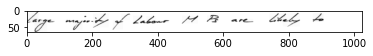

tensor([ 18,  18,  18,  18,  18,  18, 115,  18,  18,  18,  18, 159, 159, 159,
         18, 115,  18,  18,  18, 159,  18, 159, 115,  18,  18,  18,  18,  18,
        115,  18, 115,  18, 115,  18,  18,  18,  18, 115,  18,  18,  18,  18,
         18,  18, 159,  18, 159, 115, 115, 115, 159, 159,  18,  18,  18,  18,
         18, 115,  18, 115,  18, 159, 159,  18, 115, 115,  18,  18,  18,  18,
         18,  18,  18,  18,  18,  18, 115,  30,  30,  18,  18,  18,  18,  18,
         30,  18,  18,  18,  18,  18, 159, 159, 115,  18,  18, 115,  18, 115,
         18,  18, 115,  18, 130, 130,  18,  18,  18,  18,  18, 115, 115,  30,
        115,  30,  30, 159,  18, 115,  18, 159, 159, 159, 159, 159, 159, 159,
        115, 159], grad_fn=<NotImplemented>)
Prediction: ['1à1ρ1à1ρ1ρà1à1à1à1à1ρ1ρàρ1à1à1ρ1à1à?1?1ρà1à1à1à1ó1à?à?ρ1à1ρàρ']
Target: large majority of Labour M Ps are likely to
torch.Size([128, 197])


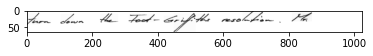

tensor([115,  18,  18,  18,  18,  18,  18,  30,  30,  30,  30, 115, 115, 115,
         18,  18,  18,  18,  18,  18,  18,  18,  18, 115,  18,  18, 159,  18,
         18, 115, 115,  18,  30, 159,  30,  18, 159, 159, 115,  18,  18,  18,
         30,  30,  30,  18, 115,  18, 159,  18,  18,  18, 115,  18,  18,  18,
         18,  18,  18, 115, 159,  18,  18,  18,  18,  18,  18,  18,  18,  30,
         18,  18, 115,  18,  18,  18,  18, 115, 115,  18,  18,  18,  18,  18,
         18, 115,  18,  18,  18, 115,  18,  18,  30,  30,  30,  18,  18, 115,
        130, 115, 159, 115, 159, 159, 115, 115, 159,  18,  18,  18, 159, 115,
        115, 115,  18, 159, 159, 159, 115, 130, 115, 130, 115, 130, 159,  18,
         18,  18], grad_fn=<NotImplemented>)
Prediction: ['à1?à1à1ρ1à1?ρ?1ρà1?1à1ρ1à1àρ1?1à1à1à1à1?1àóàρàρàρ1ρà1ρàóàóàóρ1']
Target: turn down the Foot-Griffiths resolution. Mr.
torch.Size([128, 197])


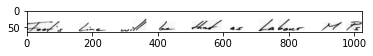

tensor([ 18,  18,  18,  18, 115, 115,  18, 115,  18,  18,  18,  30,  30, 115,
         18, 115,  18,  18,  18, 115,  18,  18,  18,  18, 115, 115, 118, 118,
        118, 118, 118, 115, 118, 118, 115, 118, 118, 115,  18,  18,  18,  18,
         18,  18,  18, 115,  18,  18, 115,  18,  18,  18, 118, 118, 118, 118,
        118,  18,  18,  18,  18,  18,  18, 115,  18,  18,  18,  18,  18,  18,
         30,  30, 115, 115, 115,  18, 118,  18,  18,  18,  18,  18,  18, 159,
        130,  18,  18,  18,  18,  18, 115, 159,  18, 115,  18,  18,  18,  18,
         18,  18,  18,  18,  18, 115,  18,  18,  18,  18,  18,  18,  18,  18,
         18,  18, 115,  18,  18,  18,  18,  18,  18, 115,  18,  18,  18,  18,
        115, 159], grad_fn=<NotImplemented>)
Prediction: ['1à1à1?à1à1à1àäàäàäà1à1à1ä1à1?à1ä1ρó1àρ1à1à1à1à1àρ']
Target: Foot's line will be that as Labour M Ps
torch.Size([128, 197])


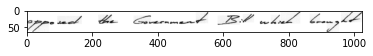

KeyboardInterrupt: ignored

In [332]:
encoder = Encoder()
dataset = IamDataset(total_imgs=20)

dataloader = DataLoader(dataset, 20)

imgs, labels = next(iter(dataloader))
preds = model(imgs).permute(1, 0, 2)

print(preds.argmax(dim=2).shape)

for pred, img, label in zip(preds, imgs, labels):
  imshow(img.squeeze(0), cmap='gray')
  print(pred.shape)
  plt.pause(.1)
  print(pred.argmax(dim=1))

  prediction = encoder.idxs_to_str_batch(pred.unsqueeze(0).argmax(dim=2))
  print('Prediction:', prediction)
  print('Target:', label)
